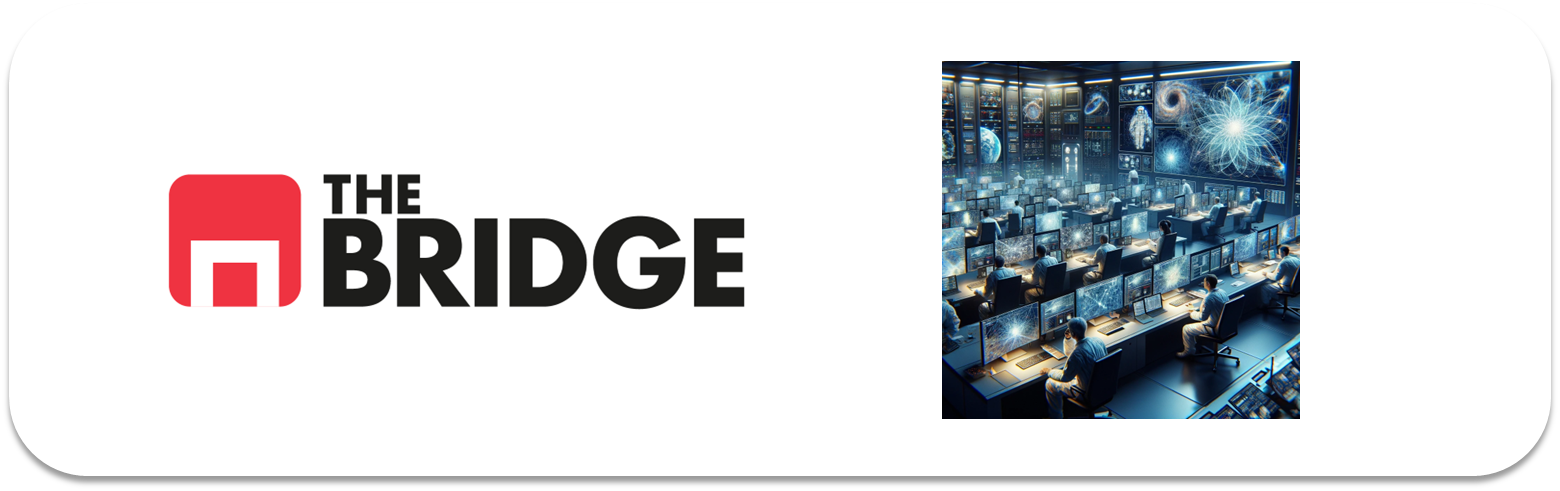

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [28]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [18]:

TRAIN_PATH = "seg_train/"
TEST_PATH =  "seg_test/"


In [40]:

def read_data(directorio, reshape_dim = (75,75)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [41]:

X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


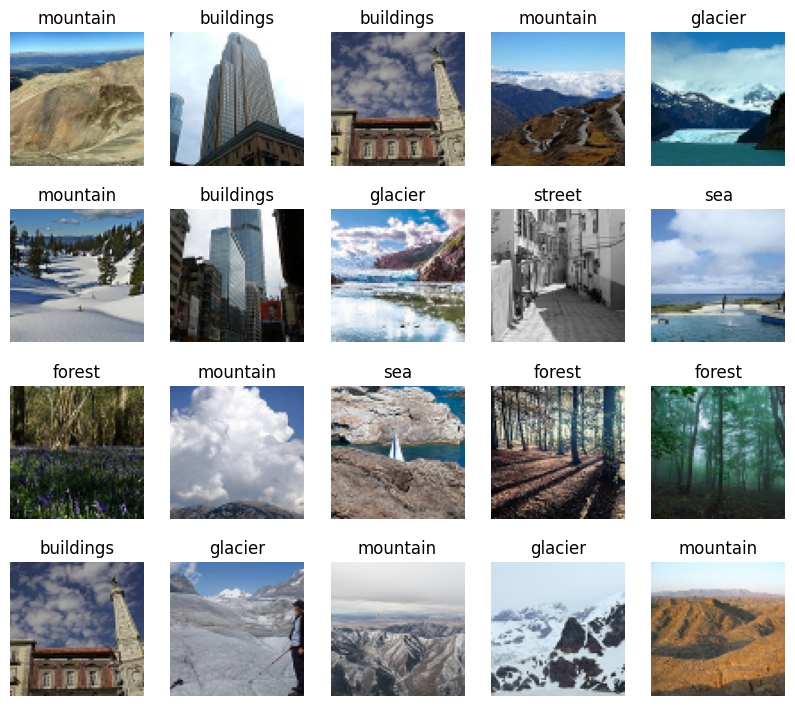

In [42]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [43]:
X_train = X_train/255
X_test = X_test/255

MODELO INTERCEPTIONv3

In [45]:
modelo = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(75,75,3),
    pooling=None,
    classifier_activation="softmax",
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [46]:
# Congelamos sus capas
for layer in modelo.layers:
    layer.trainable = False


# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = modelo): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)
    
    # Tantas unidades como el flatten de la salida de Inception -> 5625 features
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc']) # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 37, 37,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 35, 35,    │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 35, 35,    │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 17, 17,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 17, 17,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 15, 15,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [47]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


In [48]:
targets = pd.Series(y_train)
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [49]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [52]:
from time import time
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    history = model.fit(X_train, 
                        y_train_num,
                        batch_size = batch_size,
                        validation_split=0.2,
                        epochs=1,)
    tiempo = round(time() - t_zero, 3)
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - acc: 0.7028 - loss: 0.8420 - val_acc: 0.1151 - val_loss: 12.1758
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 25.728, tiempo 20 épocas: 514.5600000000001
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - acc: 0.6834 - loss: 0.8693 - val_acc: 0.0716 - val_loss: 12.5578
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 20.543, tiempo 20 épocas: 410.86
117/117 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - acc: 0.6615 - loss: 0.9140 - val_acc: 0.1169 - val_loss: 14.6362
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 18.386, tiempo 20 épocas: 367.71999999999997
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - acc: 0.6531 - loss: 0.9513 - val_acc: 0.1169 - val_loss: 15.3895
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 17.238, tiempo 20 épocas: 344.76


In [53]:
batch_size

128

In [54]:
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [55]:
from sklearn.utils import shuffle
X_train_s,y_train_s = shuffle(X_train, y_train_num)

In [56]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - acc: 0.6235 - loss: 1.0349 - val_acc: 0.7691 - val_loss: 0.6385
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - acc: 0.8194 - loss: 0.4834 - val_acc: 0.7674 - val_loss: 0.6387
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - acc: 0.8726 - loss: 0.3562 - val_acc: 0.7859 - val_loss: 0.6177
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - acc: 0.9174 - loss: 0.2449 - val_acc: 0.7788 - val_loss: 0.6379
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - acc: 0.9474 - loss: 0.1719 - val_acc: 0.7745 - val_loss: 0.7288
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - acc: 0.9723 - loss: 0.1125 - val_acc: 0.7855 - val_loss: 0.7280
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - acc: 0.9879 - loss: 0.0636 - val_acc: 0.7781 - val_loss: 0.7643
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - acc: 0.9923 - loss: 0.0464 - val_acc: 0.7866 - val_loss: 0.7914
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/

In [57]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - acc: 0.8106 - loss: 0.5153


[0.6164116859436035, 0.7776666879653931]

In [58]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step


In [59]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.81      0.84      0.82       437
      forest       0.94      0.95      0.94       474
     glacier       0.72      0.63      0.68       553
    mountain       0.64      0.72      0.68       525
         sea       0.74      0.78      0.76       510
      street       0.85      0.78      0.81       501

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



#FINING TUNNING

In [61]:
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights=None, input_shape=(75,75, 3))

# Congelamos sus capas
#for layer in base_model.layers:
#    layer.trainable = False


# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)
    
    # Tantas unidades como el flatten de la salida de Inception
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    
    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 37, 37,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 35, 35,    │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 35, 35,    │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 17, 17,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 17, 17,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 15, 15,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 25,976,998 (99.09 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [62]:
from time import time
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    history = model.fit(X_train_s, 
                        y_train_s,
                        batch_size = batch_size,
                        validation_split=0.2,
                        epochs=1,)
    tiempo = round(time() - t_zero, 3)
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 225ms/step - acc: 0.4454 - loss: 1.7089 - val_acc: 0.2376 - val_loss: 2.5854
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 98.417, tiempo 20 épocas: 1968.3400000000001
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 361ms/step - acc: 0.4651 - loss: 1.8022 - val_acc: 0.2465 - val_loss: 14049.5879
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 82.68, tiempo 20 épocas: 1653.6000000000001
117/117 ━━━━━━━━━━━━━━━━━━━━ 81s 536ms/step - acc: 0.4218 - loss: 1.6549 - val_acc: 0.2358 - val_loss: 449.3940
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 81.738, tiempo 20 épocas: 1634.76
88/88 ━━━━━━━━━━━━━━━━━━━━ 84s 737ms/step - acc: 0.5134 - loss: 1.2240 - val_acc: 0.4678 - val_loss: 2.4059
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 84.149, tiempo 20 épocas: 1682.98


In [63]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 88s 777ms/step - acc: 0.5930 - loss: 1.1044 - val_acc: 0.3979 - val_loss: 95.0433
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 71s 804ms/step - acc: 0.7230 - loss: 0.7699 - val_acc: 0.5682 - val_loss: 6.6140
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 71s 811ms/step - acc: 0.7677 - loss: 0.6573 - val_acc: 0.6559 - val_loss: 1.9480
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 840ms/step - acc: 0.7976 - loss: 0.5712 - val_acc: 0.4147 - val_loss: 168.3473
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 820ms/step - acc: 0.8152 - loss: 0.5292 - val_acc: 0.6106 - val_loss: 1.1424
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 822ms/step - acc: 0.8399 - loss: 0.4713 - val_acc: 0.5714 - val_loss: 1.2644
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 817ms/step - acc: 0.8135 - loss: 0.5476 - val_acc: 0.2483 - val_loss: 19.2602
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 71s 803ms/step - acc: 0.7590 - loss: 0.6774 - val_acc: 0.6014 - val_loss: 1.6655
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 79

In [64]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - acc: 0.4456 - loss: 66.4956


[78.23845672607422, 0.39766666293144226]

In [65]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step


In [66]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.65      0.41      0.50       437
      forest       0.29      0.97      0.44       474
     glacier       0.81      0.04      0.07       553
    mountain       0.42      0.04      0.08       525
         sea       0.37      0.50      0.42       510
      street       0.73      0.51      0.60       501

    accuracy                           0.40      3000
   macro avg       0.54      0.41      0.35      3000
weighted avg       0.55      0.40      0.34      3000

